# Augmentations and Weighted Dice U-Net


## Description

**Kaggle mean Intersection over Union** : 0.45

**Local test mean Intersection over Union**: 0.45

**Description**: Weighted Dice Loss and a deeper UNet architecture with augmentation

**Conclusions**: No meaningful improvement but the training is way more stable

## Google Drive - Connecting to the project

In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
project_path = "/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 2"
%cd {project_path}
sys.path.append(project_path)

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 2


## Imports

In [2]:
%load_ext autoreload
%autoreload 2

# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Import necessary modules
import logging
import random
import numpy as np
import pandas as pd

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

from datetime import datetime
from tensorflow.keras.metrics import MeanIoU

## Parameters

In [3]:
#Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 10

# Set dynamic LR scheduler patience
LR_PATIENCE = 5

# Set maximum number of training epochs
EPOCHS = 1000

# Number of classes
NUM_CLASSES = 5

## Load Data

In [4]:
# Load the dataset
data = np.load("dataset/cleaned_normalized_dataset.npz")

# Split the dataset in images and labels array
X = data['images']
y = data['labels']
X_test = data['test_set']
img_test = data['test_set']

In [5]:
# Normalize all the data into the 0-1 range
maxv = max(X.max(), X_test.max())
minv = min(X.min(), X_test.min())
X = (X - minv) / (maxv - minv)
X_test = (X_test - minv) / (maxv - minv)

# Convert labels to one-hot
y = tfk.utils.to_categorical(y, num_classes=NUM_CLASSES)

In [6]:
# Split the dataset into training, test, and validation
X_train, test_img_local, y_train, test_lbl_local = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

In [7]:
# A series of augmentation functions
def expand(image, label):
    return tf.expand_dims(image, axis=-1), tf.expand_dims(label, axis=-1)

def squeeze(image, label):
    return tf.squeeze(image, axis=-1), tf.squeeze(label, axis=-1)

# Flips the image and label horizontally.
def flip_lr(image, label):
    image, label = expand(image,label)
    image = tf.image.flip_left_right(image)
    label = tf.reverse(label, axis=[1])
    image, label = squeeze(image, label)
    return image, label

def flip_ud(image, label):
    image, label = expand(image,label)
    image = tf.image.flip_up_down(image)
    label = tf.reverse(label, axis=[0])
    image, label = squeeze(image, label)
    return image, label

# the following augmentations don't seem good
def random_brightness(image, label):
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
    return image, label

def random_contrast(image, label):
    image = tf.expand_dims(image, axis=-1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
    image = tf.squeeze(image, axis=-1)
    return image, label

# the following augmentations look similar
def random_noise(image, label):
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.02, dtype=tf.float32)
    image = tf.add(image, noise)
    image = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
    return image, label

def random_speckle_noise(image, label):
  noise = image * tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.2)
  image = image + noise
  return tf.clip_by_value(image, 0.0, 1.0), label

def random_haze(image, label):
  haze = tf.random.uniform(shape=tf.shape(image), minval=0.0, maxval=0.1)
  image = image + haze
  return tf.clip_by_value(image, 0.0, 1.0), label

# dk
def random_gamma(image, label, min_gamma=0.8, max_gamma=1.5):
  gamma = tf.random.uniform([], min_gamma, max_gamma)
  image = tf.image.adjust_gamma(image, gamma=gamma)
  return image, label

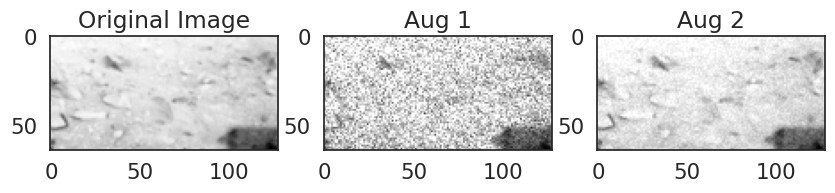

In [8]:
# Get the first image and label from the training set
image, label = X_train[0], y_train[0]

# Apply augmentations (using previously defined functions)
augmented_image1, augmented_label1 = random_speckle_noise(image, label)
augmented_image2, augmented_label2 = random_haze(image, label)

# Plot the original and augmented images
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Aug 1")
plt.imshow(augmented_image1, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Aug 2")
plt.imshow(augmented_image2, cmap='gray')

plt.show()

In [9]:
def preprocess(image, label):
    if tf.random.uniform(()) > 0.5:
        image, label = flip_lr(image, label)
    if tf.random.uniform(()) > 0.5:
        image, label = flip_ud(image, label)

    if tf.random.uniform(()) > 0.3:
        if tf.random.uniform(()) > 0.5:
            image, label = random_speckle_noise(image, label)
        else:
            image, label = random_haze(image, label)

    if tf.random.uniform(()) > 0.5:
        image, label = random_contrast(image, label)
    return image, label

In [10]:
# Function to create a dataset with batch and shuffle
def make_dataset(images,labels,batch_size, shuffle=True, augment=False, seed=None):
    images = images.astype(np.float32)
    labels = labels.astype(np.float32)
    dataset = tf.data.Dataset.from_tensor_slices((images,labels))

    # Augment the dataset if requested
    if augment:
        expansions = 3
        new_dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        for _ in range(expansions-1):
            processed = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
            new_dataset = new_dataset.concatenate(processed)
        dataset = new_dataset

    # Shuffle the dataset if requested
    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [11]:
# Create the training dataset
train_dataset = make_dataset(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True, augment=True, seed=seed)

# Create the validation dataset
val_dataset = make_dataset(X_val, y_val, batch_size=BATCH_SIZE, shuffle=False, augment=False, seed=seed)

Original training samples shape: (1598, 64, 128)
Number of training samples 4800


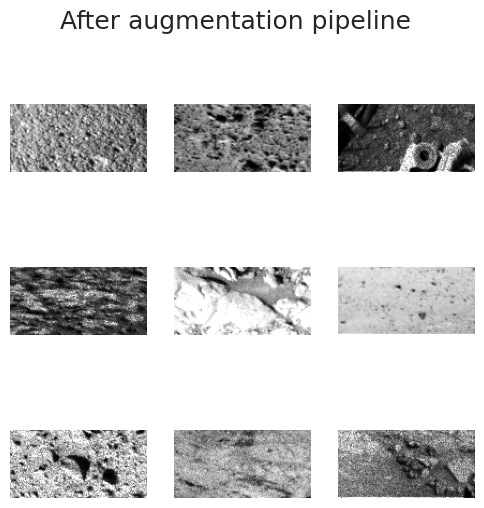

In [12]:
print("Original training samples shape:", X_train.shape)
print("Number of training samples", len(list(train_dataset))*BATCH_SIZE)

def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6))
    plt.suptitle(title, fontsize=18)
    for i, (images, labels) in enumerate(dataset.take(9)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0],cmap='gray')
        plt.axis("off")
    plt.show()

# Visualize the dataset
visualize_dataset(train_dataset, title="After augmentation pipeline")

## Model Implementation


In [13]:
# Definition of a U-net block
def unet_block(input_tensor, filters, kernel_size=3, stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.LeakyReLU(alpha=0.1, name=name + 'lrelu' + str(i + 1))(x)

    return x

In [14]:
# Definition of the model
def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 128, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)

    # Bottleneck
    bottleneck = unet_block(d3, 256, name='bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D(interpolation='bilinear')(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_3])
    u1 = unet_block(u1, 128, name='up_block1_')

    u2 = tfkl.UpSampling2D(interpolation='bilinear')(u1)
    u2 = tfkl.Concatenate()([u2, down_block_2])
    u2 = unet_block(u2, 64, name='up_block2_')

    u3 = tfkl.UpSampling2D(interpolation='bilinear')(u2)
    u3 = tfkl.Concatenate()([u3, down_block_1])
    u3 = unet_block(u3, 32, name='up_block3_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u3)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

In [15]:
# Model contruction
model = get_unet_model()

# Print a detailed summary of the model
model.summary(expand_nested=False, show_trainable=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv1      │ (None, 64, 128, 32)  │          320 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn1        │ (None, 64, 128, 32)  │          128 │ down_block1_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_lrelu1     │ (None, 64, 128, 32)  │            0 │ down_block1_bn1[0]… │    -    │
│ (LeakyReLU)            │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv2      │ (None, 64, 128, 32)  │        9,248 │ down_block1_lrelu1… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn2        │ (None, 64, 128, 32)  │          128 │ down_block1_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_lrelu2     │ (None, 64, 128, 32)  │            0 │ down_block1_bn2[0]… │    -    │
│ (LeakyReLU)            │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 64, 32)   │            0 │ down_block1_lrelu2… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv1      │ (None, 32, 64, 64)   │       18,496 │ max_pooling2d[0][0] │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn1        │ (None, 32, 64, 64)   │          256 │ down_block2_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_lrelu1     │ (None, 32, 64, 64)   │            0 │ down_block2_bn1[0]… │    -    │
│ (LeakyReLU)            │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv2      │ (None, 32, 64, 64)   │       36,928 │ down_block2_lrelu1… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn2        │ (None, 32, 64, 64)   │          256 │ down_block2_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├──────────────────────

 Total params: 1,952,069 (7.45 MB)

 Trainable params: 1,949,253 (7.44 MB)

 Non-trainable params: 2,816 (11.00 KB)

## Training

In [16]:
labels = data['labels']
# Counting class frequency
flattened_labels = labels.flatten().astype(int)
frequencies = np.bincount(flattened_labels)
print(frequencies)
print(sum(frequencies))
# Calculate inverse frequency weights
class_weights = 1 / (frequencies / np.sum(frequencies))

[4931482 6957538 4776810 3770823   26963]
20463616


In [17]:
# Custom implementation  of Weighted Dice loss
def weighted_dice_loss(class_weights):
    def loss(y_true, y_pred):
        smooth = 1e-6
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Per-class weights
        weights = tf.constant([class_weights[c] for c in range(len(class_weights))], dtype=tf.float32)
        weights = tf.reshape(weights, [1, 1, 1, -1])  # Match shape of y_pred

        # Dice components
        intersection = tf.reduce_sum(weights * y_true * y_pred, axis=[1, 2])  # sum over height and width
        union = tf.reduce_sum(weights * (y_true + y_pred), axis=[1, 2])  # sum over height and width

        # Weighted Dice score per class
        dice = (2. * intersection + smooth) / (union + smooth)
        return 1 - tf.reduce_mean(dice)  # Mean over all classes
    return loss

loss = weighted_dice_loss(class_weights)

In [18]:
# Model compilation with Adam as optimizer and Weighted Dice as loss function
model.compile(
    loss=loss,
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    metrics=[tfk.metrics.OneHotMeanIoU(NUM_CLASSES,ignore_class=0,name='meanIoU')])

In [19]:
# Implementation of early stopping as a technique to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_meanIoU',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)
# Implementation of reduce learning rate on plateau
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_meanIoU',
    mode='max',
    factor=0.1,
    patience=LR_PATIENCE,
    min_lr=1e-5,
)

callbacks = [early_stopping, reduce_lr_on_plateau]

In [20]:
# Actual training of the model with the given parameters
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1,
).history

Epoch 1/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 38s 224ms/step - loss: 0.8513 - meanIoU: 0.1862 - val_loss: 0.9488 - val_meanIoU: 0.0573 - learning_rate: 0.0010
Epoch 2/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.8020 - meanIoU: 0.2719 - val_loss: 0.9384 - val_meanIoU: 0.0575 - learning_rate: 0.0010
Epoch 3/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.7916 - meanIoU: 0.2941 - val_loss: 0.9272 - val_meanIoU: 0.0696 - learning_rate: 0.0010
Epoch 4/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.7841 - meanIoU: 0.3084 - val_loss: 0.9152 - val_meanIoU: 0.0820 - learning_rate: 0.0010
Epoch 5/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.7817 - meanIoU: 0.3187 - val_loss: 0.8696 - val_meanIoU: 0.1594 - learning_rate: 0.0010
Epoch 6/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.7767 - meanIoU: 0.3288 - val_loss: 0.8164 - val_meanIoU: 0.2640 - learning_rate: 0.0010
Epoch 7/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.7737 - meanIoU: 0.3441 - val_

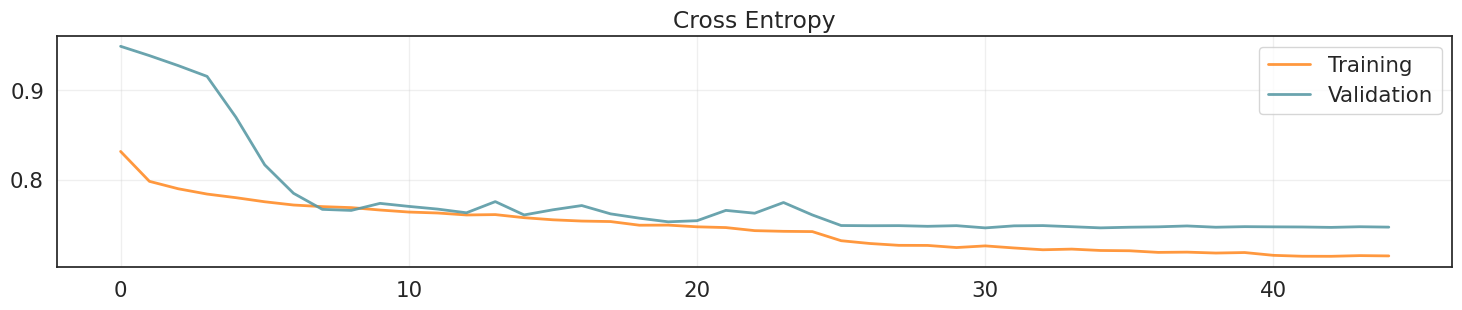

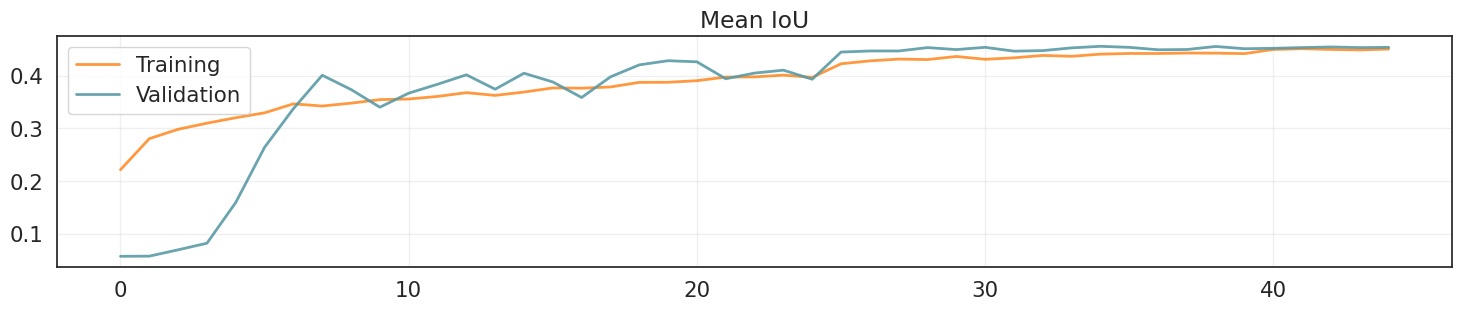

In [21]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation meanIoU
plt.figure(figsize=(18, 3))
plt.plot(history['meanIoU'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_meanIoU'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean IoU')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Test Prediction and Final Evaluation

In [22]:
# Predict class probabilities and get predicted classes
test_predictions = model.predict(test_img_local, verbose=0)
test_predictions = np.argmax(test_predictions, axis=-1)
test_lbl_local = np.argmax(test_lbl_local, axis=-1)

In [23]:
# Calculate and display test set accuracy
test_accuracy = accuracy_score(test_lbl_local.flatten(), test_predictions.flatten())
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision
test_precision = precision_score(test_lbl_local.flatten(), test_predictions.flatten(), average='weighted', zero_division=0)
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall
test_recall = recall_score(test_lbl_local.flatten(), test_predictions.flatten(), average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score
test_f1 = f1_score(test_lbl_local.flatten(), test_predictions.flatten(), average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

# Calculate and display test set mean Intersection Over Union score
# one_hot_pred = tfk.utils.to_categorical(test_predictions, num_classes=NUM_CLASSES)
test_miou = MeanIoU(NUM_CLASSES)
test_miou.update_state(test_lbl_local, test_predictions)
test_miou = test_miou.result().numpy()
print(f'Mean Intersection over Union over the test set: {round(test_miou, 4)}')

Accuracy score over the test set: 0.7298
Precision score over the test set: 0.7212
Recall score over the test set: 0.7298
F1 score over the test set: 0.72
Mean Intersection over Union over the test set: 0.45410001277923584


## Save

In [24]:
from datetime import datetime

current_time = datetime.now().strftime("%d|%m-%H:%M")

model_filename = f'UNet_{current_time}.keras'
print("Saved as :",model_filename)

# Storing the model, while ignoring the optimizer
model.save(f'models/{model_filename}', include_optimizer=False)

Saved as : UNet_14|12-15:55.keras


## Submission

In [28]:
# Predict the masks for the submission
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)

314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


In [29]:
# Converts segmentation predictions into a DataFrame format for Kaggle
def y_to_df(y) -> pd.DataFrame:
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [30]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submissions/submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)